# Detectron2 (FAIR)


In [2]:
import detectron2
import contextlib
import datetime
import io
import os
import json
import logging
import cv2
import random
import numpy as np
import copy,torch,torchvision
import PIL
from PIL import Image
import xml.etree.ElementTree as X
import math
from itertools import repeat

from detectron2.structures import Boxes, BoxMode, PolygonMasks
from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import COCOEvaluator,DatasetEvaluators, inference_on_dataset, coco_evaluation, DatasetEvaluator
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

import glob
import time
import shutil
from multiprocessing.pool import ThreadPool
import concurrent.futures

from utility.LossEvalHook import LossEvalHook
from utility.mytrainer import MyTrainer
from utility.nms import non_max_suppression_fast

import torch
torch.cuda.set_device(0)

setup_logger()

<Logger detectron2 (DEBUG)>

## Dataset registration
### Ship Dataset:

In [3]:
# register_coco_instances("ship_dataset_train", {}, "ShipAnnotations/train2017.json", "ShipDataset")
# register_coco_instances("ship_dataset_val", {}, "ShipAnnotations/test2017.json", "ShipDataset")

## Wake Dataset:

In [4]:
# register_coco_instances("wake_dataset_train", {}, "Sar Wakes 3/train/coco.json", "Sar Wakes 3/train/imgs")
# register_coco_instances("wake_dataset_val", {}, "Sar Wakes 3/validation/coco.json", "Sar Wakes 3/validation/imgs")
# # MetadataCatalog.get("wake_dataset_train").set(thing_classes=["wake"])

## OpticalWake Dataset:

In [5]:
register_coco_instances("OPT_train", {}, "OpticalWake/Annotations/train.json", "OpticalWake/Immagini_train")
register_coco_instances("OPT_val", {}, "OpticalWake/Annotations/train.json", "OpticalWake/Immagini_train")
# register_coco_instances("OPT_val", {}, "OpticalWake/Annotations/test.json", "OpticalWake/Immagini_test")

## Setup configuration
Now we've got out data in a usable form,and some useful functions lets configure our tests. below are the options for training, 

In [6]:
cfg = get_cfg()
cfg.OUTPUT_DIR = 'output'
#  Let training initialize from models.txt
# MODEL = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"    #"Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"
# MODEL = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"    #"Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"
MODEL = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"       #"Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"

cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL) #
cfg.DATASETS.TRAIN = ("OPT_train",)
cfg.DATASETS.TEST = ("OPT_val",)

# cfg.MODEL.MASK_ON=False
th_test = 0.5
chkpt = 1000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = th_test
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = th_test
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # this is far lower than usual.  
cfg.MODEL.ROI_HEADS.NUM_CLASSES =  1             # only has one class.
cfg.MODEL.RETINANET.NUM_CLASSES =  1

cfg.SOLVER.IMS_PER_BATCH = 1          
cfg.SOLVER.CHECKPOINT_PERIOD = chkpt
cfg.TEST.EVAL_PERIOD = chkpt
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.STEPS=[2000,4000,6000,8000]
cfg.SOLVER.MAX_ITER=10000

cfg.MODEL.PIXEL_MEAN = [100, 100, 100]
cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) #lets just check our output dir exists


cfg.MODEL.RETINANET.FOCAL_LOSS_ALPHA = 0.5
cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA = 2.0

tot_img = 780
epochs = (cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE*cfg.SOLVER.MAX_ITER)/tot_img
print(f'Epochs:{round(epochs)}')

Epochs:1641


## Training
### Load tensorboard to view progress

In [ ]:
# # Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir {cfg.OUTPUT_DIR}

### Start training

In [ ]:
# # cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = 'checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/model_0002979.pth'
# trainer = MyTrainer(cfg) 
# trainer.resume_or_load(resume=False) # Inference mode

# ###### TRAINING #######
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=True) # Training mode
trainer.train()

## Evaluation

The results produced about aren't as accurate as those performed outside of training. So let's rerun our evaluations. 

In [ ]:
# # !python3 PlotTogether.py
import json
from os import path
import matplotlib.pyplot as plt

plt.style.use(['science','notebook','high-vis'])


# experiment_folder = './output/model_iter4000_lr0005_wf1_date2020_03_20__05_16_45'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

# experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
path = 'output_2/metrics.json'
# path = 'checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/metrics.json'
experiment_metrics = load_json_arr(path)
fig, ax1 = plt.subplots(dpi=150, figsize=(15,7))
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss Value')
# ax1.plot(
    # [x['iteration'] for x in experiment_metrics], 
    # [x['bbox_loss'] for x in experiment_metrics], color="black", label="Total Loss")
color = 'tab:blue'
retinanet=True

# if retinanet:
ax1.plot(
        [x['iteration'] for x in experiment_metrics if 'data_time' in x], 
        [x['total_loss'] for x in experiment_metrics if 'data_time' in x], color=color, label="Total Loss")
# else:
ax1.plot(
        [x['iteration'] for x in experiment_metrics if ('total_loss' in x) & ('bbox/AP' in x)], 
        [x['total_loss'] for x in experiment_metrics if ('total_loss' in x) & ('bbox/AP' in x)], color=color, label="Validation Loss")

plt.legend(['Training Loss','Validation Loss'],loc='upper left', bbox_to_anchor = [0.75, 0.99])
 
# plt.plot(
#     [x['iteration'] for x in experiment_metrics], 
#     [x['total_loss'] for x in experiment_metrics])
# plt.plot(
#     [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
#     [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
# plt.plot(
#     [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
#     [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x])



# plt.legend(['validation_loss','AP'], loc='upper left')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('AP')
ax2.plot(
    [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x], 
    [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x], color=color)
ax2.tick_params(axis='y')

plt.legend(['$mAP$'],loc='upper right', bbox_to_anchor = [0.75, 0.99])
plt.title('Cascade Mask R-CNN with ResNet-50 + FPN backbone')

plt.xlim([-100, 10100])
plt.ylim([0, 100])
# plt.savefig('checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/AP_Loss.eps', format='eps')
# plt.savefig('checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/AP_Loss.png')
plt.show()



# Inference

In [7]:
# Create coco evaluator, but use the default detectron2 data format for generation, make sure ids overlap
weight_path = 'OpticalWake/Results/output_2/model_final.pth'
# weight_path = 'checkpoints/Model Trained Wake/retinanet_R_50_FPN_3x/model_0004999.pth'
# weight_path = 'checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/model_0002979.pth'
####################################################################################################
th_test = 0.55
cfg.MODEL.WEIGHTS = weight_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = th_test
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = th_test
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False) # Inference mode

[11/07 17:24:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
# evaluator = COCOEvaluator("OPT_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
# val_loader = build_detection_test_loader(cfg, "OPT_val") 
# outputs = inference_on_dataset(trainer.model, val_loader, evaluator)

# Create Detector

In [8]:
# cfg.MODEL.WEIGHTS = "checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/model_0002979.pth"
# cfg.MODEL.WEIGHTS = "checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/model_0002979.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [ ]:
# from utility.myVisualizer import MyVisualizer
# # test_dict = get_dataset("wake_dataset_val")
# test_img = glob.glob('Sar Wakes 3/validation/imgs/*.png')
# i = 0
# for d in random.sample(test_img, 20):
#   i+=1
#   im = cv2.imread(d)
#   outputs = predictor(im)  
#   v = MyVisualizer(im[:, :, ::-1],
#                   metadata=MetadataCatalog.get("wake_dataset_val"), 
#                   scale=1)

 
#   out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#   plt.figure(figsize=(10,10))
#   # plt.imshow(out.get_image()[:, :, ::-1])
#   cv2.imwrite(f'Val_fig/Val_{i}.png', out.get_image()[:, :, ::-1])
#   # plt.axis(False)
#   # plt.show()

In [ ]:
  from utility.myVisualizer import MyVisualizer
  from glob import glob

  imgs = glob('OpticalWake/Immagini_test/*')
  i = 0
  for img in imgs:
    i=i+1
    # im = cv2.imread(f'OpticalWake/Immagini_train/{i}.png')
    im = cv2.imread(img)
    # im = im[800:1800,450:1450]
    outputs = predictor(im)  
    v = MyVisualizer(im[:, :, ::-1],
                    metadata=MetadataCatalog.get("OPT_val"), 
                    scale=1)

  
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,15))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis(False)
    plt.savefig(f'OpticalWake/Results/Figures/{i}_det.png')
    plt.show()

 # Tests on complete SAR images

## 16bit Integration:

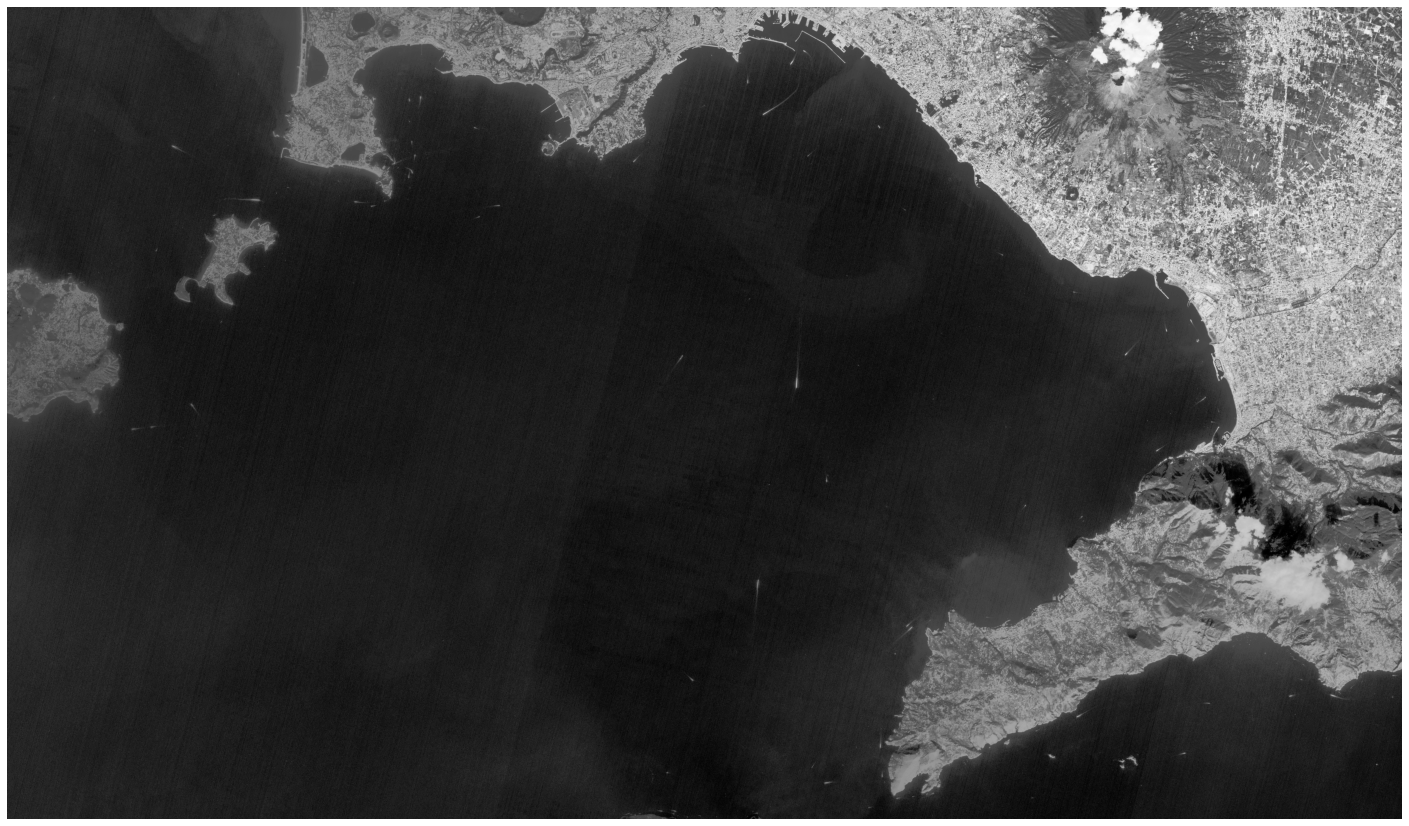

In [44]:
img = cv2.imread('/home/coast-unina/Documenti/Python Projects/Detectron2/OpticalWake/ScenarioTest/ScenarioTest_GolfodiNapoli.tif',-1)
# img = img.astype('float32')
                                        #    MIN         MAX
clahe = cv2.createCLAHE(clipLimit = 350, tileGridSize=(2,2))
img_equ = clahe.apply(img)

# cv2.imshow("img", img_equ); cv2.waitKey(0); cv2.destroyAllWindows() # Enter to close
# img_scaled = cv2.normalize(img_equ, dst=None, alpha=0, beta=256, norm_type=cv2.NORM_MINMAX).astype('uint8')



plt.figure(figsize=(25,25))
plt.imshow(img_equ, cmap='gray')
plt.axis(False)
plt.show()

In [45]:
from utility.printProgressBar import printProgressBar
# for thresh in list(np.round(np.arange(0.5,0.99, 0.05),2)):
# path =  'Results Wake/ScenariTest/Revisori/'
# prod_list = glob.glob(path+'*')
# for prod in prod_list:
for prod in range(1):
        # prod = 'Results Wake/ScenariTest/GolfodiNapoli/S1A_IW_GRDH_1SDV_20211019T165718_20211019T165743_040191_04C2B3_6D31_msk_Cnv.tif'
        # im = cv2.imread(prod) #Scenario3_additional.tif

        im = cv2.imread('/home/coast-unina/Documenti/Python Projects/Detectron2/OpticalWake/ScenarioTest/ScenarioTest_GolfodiNapoli.tif',-1)
        # CLAHE
        clahe = cv2.createCLAHE(clipLimit = 350, tileGridSize=(2,2))
        img_equ = clahe.apply(im)
        # SCALE 
        img_scaled = cv2.normalize(img_equ, dst=None, alpha=0, beta=256, norm_type=cv2.NORM_MINMAX).astype('uint8')
        im = np.stack((img_scaled,)*3, axis=-1)

        y,x = im.shape[0], im.shape[1] 
        step, ws = 125, 1024 # Step and windows size to be moved
        range_x, range_y = np.arange(ws, x-ws, step), np.arange(ws, y-ws, step)
        print(f"Number of subsets to be analyzed: {len(range_x)*len(range_y)}")

        Bboxes = []
        i=0
        for space_x in range_x:
            for space_y in range_y:
                i+=1
                printProgressBar(i, len(range_x)*len(range_y), printEnd=' ')
                img = im[(space_y-ws):(space_y+ws),(space_x-ws):(space_x+ws)]
                outputs = predictor(img)
                bboxes=outputs["instances"].pred_boxes.tensor.cpu().numpy()
                for b in bboxes: 
                    # Each row is (x1, y1, x2, y2).
                    b[0], b[1], b[2], b[3] = b[0]+space_x-ws, b[1]+space_y-ws, b[2]+space_x-ws, b[3]+space_y-ws
                    Bboxes.append(b)

        Bboxes_arr = np.array(Bboxes)
        bboxes_draw = non_max_suppression_fast(Bboxes_arr, 0.33)
        for box in bboxes_draw:
            # represents the top left corner of rectangle
            start_point =  (box[0], box[1])
            # represents the bottom right corner of rectangle
            end_point = (box[2], box[3])
            color = (255, 0, 0)
            linethickness = 3
            image = cv2.rectangle(im, start_point, end_point, color, linethickness)
        if image is not None:
            cv2.imwrite(f'OpticalWake/Results/Out_ScenarioTest/out.tiff', image)
            print('Done.')  

Number of subsets to be analyzed: 252
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  
Done.


In [ ]:
im = cv2.imread('Results Wake/ScenariTest/S1A_IW_GRDH_1SDV_20200706T171436_20200706T171501_033337_03DCC6_1122_msk_Cnv.tif') #Scenario3_additional.tif


In [ ]:
tmp = im[11000:12000,4000:5000]
plt.figure(figsize=(10,10))
plt.imshow(tmp)

In [ ]:
image_tsx = cv2.imread('Results Wake/TSX.png')

In [ ]:
# cfg.MODEL.WEIGHTS = "checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/model_0002979.pth"
cfg.MODEL.WEIGHTS = "checkpoints/Model Trained Wake/cascade_mask_rcnn_R_50_FPN_3x/model_0002979.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1 
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
predictor(image_tsx)

# Other Tests

In [ ]:
from utility.myVisualizer import MyVisualizer
im = cv2.imread('ScenariTest/ShipWakeTerraSAR-X/VV.tiff')
# test = im[5000+2200:6000+2200,4500:5500]
test = im[7000+3000:9000+3000,6100:8100]
test = (test - test.min())/(0.64)

outputs = predictor(test)  
v = MyVisualizer(test[:, :, ::-1],
                  metadata=MetadataCatalog.get("wake_dataset_val"), 
                  scale=1)
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  # )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10,10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis(False)
# cv2.imwrite('TSX.png', out.get_image()[:, :, ::-1])
# cv2.imwrite('TSX_clean.png', test)
plt.show()

In [ ]:
im = cv2.imread('ScenariTest/ShipWakeTerraSAR-X/VV.tiff')
test = im[7000+3000:9000+3000,6100:8100]
# test = im[5500+1000:8500+1000,4100:7100]
cv2.imwrite('TSX.png', out.get_image()[:, :, ::-1])

plt.figure(figsize=(10,10))
plt.imshow(test)
plt.axis(False)
plt.show()


In [ ]:
test.shape

In [ ]:
path = 'Oceans/scenario2_en.tif'
im = cv2.imread(path)
test = im[250:1250,500:1500]
# test = (test - test.min())/(0.75)

outputs = predictor(test)  
v = MyVisualizer(test[:, :, ::-1],
                  metadata=MetadataCatalog.get("wake_dataset_val"), 
                  scale=1)
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  # )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite('sc2.png', out.get_image()[:, :, ::-1])
cv2.imwrite('sc2_clean.png', test)
plt.figure(figsize=(10,10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis(False)
plt.show()

In [ ]:
# im = cv2.imread('ScenariTest/ShipWakeTerraSAR-X/VV.tiff')
# test = im[7000+4000:9000+4000,6100:8100]
# outputs = predictor(test)  

# bboxes=outputs["instances"].pred_boxes.tensor.cpu().numpy()
# for box in bboxes:
#     start_point =  (box[0], box[1])
#         # represents the bottom right corner of rectangle
#     end_point = (box[2], box[3])
#     color = (255, 0, 0)
#     linethickness = 5
#     image = cv2.rectangle(test, start_point, end_point, color, linethickness)
# cv2.imwrite('ImageTest.png', image) 

In [ ]:
bboxes